# BIZ 프로젝트 : 부실기업 예측 모형에 관한 연구

## Step3 : 모델링 ver3 (확장)

할거 : 21,22(2개년도)년도 데이터로 부실기업 예측 대시보드 형식으로 시각화

### 0. 라이브러리 및 데이터 불러오기

라이브러리 불러오기

In [145]:
import numpy as np
import tensorflow as tf
import random
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

폰트 지정

In [146]:
import platform
from matplotlib import rc

# 운영 체제에 따라 폰트 설정
if platform.system() == 'Windows':  # Windows 환경
    rc('font', family='Malgun Gothic')  # 맑은 고딕

# 음수 표시 가능하도록 설정
plt.rcParams['axes.unicode_minus'] = False

데이터 불러오기(21 to 22 2개년도 데이터)

In [147]:
RANDOM_STATE = 110
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

data_21to22 = pd.read_csv("../../project/data/data_21to22.csv", encoding='utf-8-sig', low_memory=False)
print(data_21to22.shape)

(27603, 90)


타겟비율 시각화

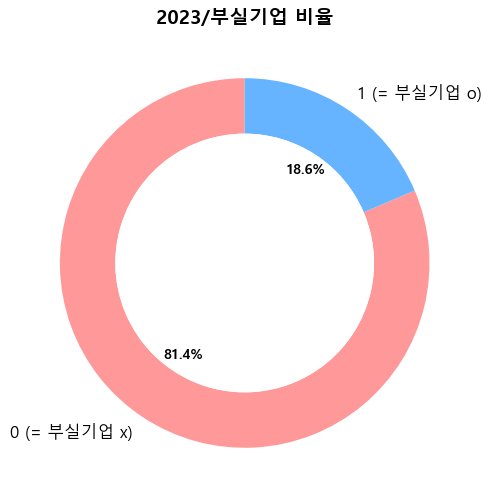

In [148]:
# '2023/부실기업' 비율 계산
value_counts = data_21to22['2023/부실기업'].value_counts()
labels = ['1 (= 부실기업 o)' if label == 1 else '0 (= 부실기업 x)' for label in value_counts.index]
sizes = value_counts.values

# 색상 설정
colors = ['#ff9999','#66b3ff']

# 도넛 차트 시각화
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))

wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3))

# 도넛 차트의 가운데에 텍스트 추가
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# 텍스트 스타일 설정
plt.setp(autotexts, size=10, weight="bold", color="black")
plt.setp(texts, size=12)

# 차트 제목 추가
plt.title('2023/부실기업 비율', fontsize=14, weight='bold')

# 차트 표시
plt.show()

데이터 불균형 -> 평가지표로 accuracy(정확도)가 아닌 F1-score를 기준으로 한다.

In [149]:
data_21to22.head()

,업체코드,종목명,상장여부,2023/부실기업,2022/총자산증가율,2022/매출액증가율,2021/영업이익증가율,2021/순이익증가율,2021/총자본영업이익율,2022/총자본영업이익율,...,2022/인건비(종업원1인당),2021/노동장비율(종업원1인당),2021/자본집약도(종업원1인당),2021/법인세차감전순이익(구성비),2022/법인세차감전순이익(구성비),2021/인건비(구성비),2021/금융비용(구성비),2022/금융비용(구성비),2021/임차료(구성비),2022/임차료(구성비)
0,N350605,동화약품,1,0,3.27,16.06,-16.09,-48.20,4.56,6.28,...,60853590.0,1.583593e+08,5.627382e+08,17.87,15.335,57.855,3.18,4.5,1.28,1.32
1,N320498,KR모터스,1,1,-0.52,-15.04,16.26,24.22,-1.02,-4.95,...,60853590.0,1.295734e+09,1.767904e+09,17.87,15.335,57.855,3.18,4.5,1.28,1.32
2,N320684,경방,1,0,-6.09,-0.71,13.04,-10.40,2.36,3.13,...,60853590.0,1.824437e+08,6.096943e+09,17.87,15.335,57.855,3.18,4.5,1.28,1.32
3,N320730,삼양홀딩스,1,0,-0.76,-40.09,218.01,225.02,12.76,3.32,...,60853590.0,1.521873e+08,3.949607e+09,17.87,15.335,57.855,3.18,4.5,1.28,1.32
4,N310581,하이트진로,1,0,-9.43,12.40,-16.74,39.18,4.61,5.06,...,60853590.0,5.633133e+08,1.039853e+09,17.87,15.335,57.855,3.18,4.5,1.28,1.32


In [150]:
data_21to22.columns

Index(['업체코드', '종목명', '상장여부', '2023/부실기업', '2022/총자산증가율', '2022/매출액증가율',
       '2021/영업이익증가율', '2021/순이익증가율', '2021/총자본영업이익율', '2022/총자본영업이익율',
       '2022/총자본법인세비용차감전순이익율', '2022/총자본순이익율', '2021/기업법인세비용차감전순이익율',
       '2022/기업법인세비용차감전순이익율', '2021/기업순이익율', '2021/경영자본영업이익율',
       '2022/경영자본영업이익율', '2022/자기자본법인세비용차감전순이익율', '2021/자기자본순이익율',
       '2021/자본금법인세비용차감전순이익율', '2022/자본금법인세비용차감전순이익율', '2021/자본금순이익율',
       '2022/자본금순이익율', '2021/매출액법인세비용차감전순이익율', '2022/매출액법인세비용차감전순이익율',
       '2022/매출액총이익율', '2022/매출액영업이익율', '2022/감가상각비/총비용비율',
       '2021/조세/조세차감전순이익비율', '2022/조세/조세차감전순이익비율', '2022/금융비용/총부채',
       '2021/차입금평균이자율', '2022/차입금평균이자율', '2021/금융비용/총비용비율', '2022/금융비용/총비용비율',
       '2021/영업이익이자보상비율', '2022/영업이익이자보상비율', '2021/법인세차감전순이익이자보상비율',
       '2022/법인세차감전순이익이자보상비율', '2022/배당성향', '2021/상환계수(세전이익)', '2021/부채상환계수',
       '2021/대출효율성계수(법인세비용차감전순이익)', '2022/EBIT대매출액(세전이익)', '2022/EBITDA대매출액',
       '2021/EBITDA대금융비용', '2022/EBITDA대금융비용', '2021/자기자본비율', '2021/당좌비율',
      

In [151]:
# 2021년과 2022년 변수 목록 추출
ratios_2021 = data_21to22.filter(like='2021').columns
ratios_2022 = data_21to22.filter(like='2022').columns

# 공통 재무 비율 찾기
common_ratios = set(ratios_2021.str.replace('2021/', '')) & set(ratios_2022.str.replace('2022/', ''))

# 결과 출력
common_ratios_list = sorted(list(common_ratios))
common_ratios_list

['EBITDA대금융비용',
 '경영자본영업이익율',
 '금융비용(구성비)',
 '금융비용/총비용비율',
 '기업법인세비용차감전순이익율',
 '매출액법인세비용차감전순이익율',
 '법인세차감전순이익(구성비)',
 '법인세차감전순이익이자보상비율',
 '사내유보율',
 '순운전자본/총자본비율',
 '순이익(종업원1인당)',
 '영업이익이자보상비율',
 '유동부채비율',
 '유보액/총자산비율',
 '임차료(구성비)',
 '자본금법인세비용차감전순이익율',
 '자본금순이익율',
 '조세/조세차감전순이익비율',
 '차입금평균이자율',
 '총자본영업이익율',
 '현금비율']

---

스레스 홀드 찾기

In [152]:
# 종속 변수 설정
y = data_21to22['2023/부실기업']

# 연도별 특성 분리
X_2021 = data_21to22.filter(like='2021')  # 2021년 데이터
X_2022 = data_21to22.filter(like='2022')  # 2022년 데이터

# 재무비율 추출 함수
def extract_ratio_columns(df, year):
    return df.columns.str.replace(f'{year}/', '')

# 2021년과 2022년의 재무비율 추출
ratios_2021 = extract_ratio_columns(X_2021, '2021')
ratios_2022 = extract_ratio_columns(X_2022, '2022')

# 공통 재무비율 찾기
common_ratios = ratios_2021.intersection(ratios_2022)

# 공통 재무비율을 포함하는 변수명 생성
common_columns_2021 = [f'2021/{ratio}' for ratio in common_ratios]
common_columns_2022 = [f'2022/{ratio}' for ratio in common_ratios]

# 공통 변수만 사용하여 데이터 결합
X_2021_common = X_2021[common_columns_2021]
X_2022_common = X_2022[common_columns_2022]

# 전체 특성 결합 (타임 스텝을 위해 배열로 변환)
X_common = pd.concat([X_2021_common, X_2022_common], axis=1)

# 데이터 분할 (70:30 비율)
X_common_train, X_common_test, y_train, y_test = train_test_split(X_common, y, test_size=0.3, random_state=RANDOM_STATE)

# 데이터 정규화
scaler_common = StandardScaler()
X_common_train_scaled = scaler_common.fit_transform(X_common_train)
X_common_test_scaled = scaler_common.transform(X_common_test)

# 변수명을 유지하기 위해 DataFrame으로 변환
X_common_train_scaled_df = pd.DataFrame(X_common_train_scaled, columns=X_common_train.columns)
X_common_test_scaled_df = pd.DataFrame(X_common_test_scaled, columns=X_common_test.columns)

# 타임 스텝 설정
timesteps = 2  # 2021년과 2022년으로 2개의 타임 스텝으로 설정  # (샘플 수, 타임 스텝, 특성 수)
X_train_lstm = X_common_train_scaled_df.values.reshape((X_common_train_scaled_df.shape[0], timesteps, -1)) 
X_test_lstm = X_common_test_scaled_df.values.reshape((X_common_test_scaled_df.shape[0], timesteps, -1))

In [153]:
# 모델 구축
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(LSTM(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=1)

# 모델 예측
predictions_proba = model.predict(X_test_lstm)
predictions = (predictions_proba > 0.5).astype(int)

# 모델 평가
accuracy = model.evaluate(X_test_lstm, y_test, verbose=0)[1]
f1 = f1_score(y_test, predictions)

print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

Epoch 1/10
604/604 [==============================] - 4s 3ms/step - loss: 0.2552 - accuracy: 0.8933
Epoch 2/10
604/604 [==============================] - 2s 3ms/step - loss: 0.1725 - accuracy: 0.9253
Epoch 3/10
604/604 [==============================] - 2s 2ms/step - loss: 0.1548 - accuracy: 0.9341
Epoch 4/10
604/604 [==============================] - 1s 2ms/step - loss: 0.1459 - accuracy: 0.9375
Epoch 5/10
604/604 [==============================] - 2s 3ms/step - loss: 0.1404 - accuracy: 0.9377
Epoch 6/10
604/604 [==============================] - 1s 2ms/step - loss: 0.1357 - accuracy: 0.9400
Epoch 7/10
604/604 [==============================] - 1s 2ms/step - loss: 0.1336 - accuracy: 0.9416
Epoch 8/10
604/604 [==============================] - 1s 2ms/step - loss: 0.1304 - accuracy: 0.9429
Epoch 9/10
604/604 [==============================] - 2s 3ms/step - loss: 0.1268 - accuracy: 0.9439
Epoch 10/10
259/259 [==============================] - 0s 1ms/step
Accuracy: 0.9347, F1 Score: 0.836

1. ROC 곡선 활용

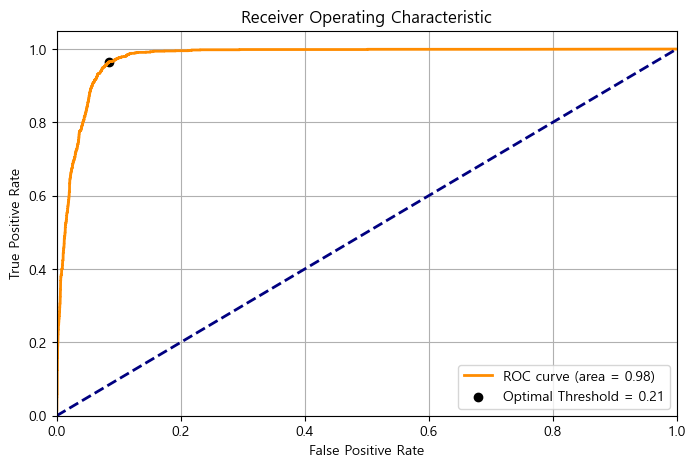

Optimal Threshold: 0.21


In [154]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def find_optimal_threshold(predictions_proba, y_test):
    fpr, tpr, thresholds = roc_curve(y_test, predictions_proba)
    roc_auc = auc(fpr, tpr)
    
    # Youden's J statistic to find the optimal threshold
    J = tpr - fpr
    ix = np.argmax(J)
    optimal_threshold = thresholds[ix]
    
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label=f'Optimal Threshold = {optimal_threshold:.2f}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    return optimal_threshold

# 함수 사용 예시
optimal_threshold = find_optimal_threshold(predictions_proba, y_test)
print(f'Optimal Threshold: {optimal_threshold:.2f}')

스레스 홀드 0.2를 부실기업 예측의 최적 스레스홀드로 지정

In [155]:
import numpy as np
from sklearn.metrics import f1_score

# 모델 예측
predictions_proba = model.predict(X_test_lstm).flatten()
predictions = (predictions_proba > 0.21).astype(int)

# 모델 평가
accuracy = model.evaluate(X_test_lstm, y_test, verbose=0)[1]
f1 = f1_score(y_test, predictions)

# 예측 확률이 0.21 이상인 기업 중 실제 부실기업의 비율 계산
predicted_defaulters_indices = predictions_proba > 0.21
predicted_defaulters = y_test[predicted_defaulters_indices]
actual_defaulters_ratio = np.mean(predicted_defaulters)

print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
print(f"Actual Defaulters Ratio among Predicted Defaulters: {actual_defaulters_ratio:.4f}")

259/259 [==============================] - 0s 1ms/step
Accuracy: 0.9347, F1 Score: 0.8249
Actual Defaulters Ratio among Predicted Defaulters: 0.7199


| 지표                          | 의미                                    | 계산식                         |
|-------------------------------|----------------------------------------|--------------------------------|
| TPR (True Positive Rate)      | 실제 양성 중에서 올바르게 예측한 비율    | (\frac{TP}{TP + FN})           | 
| FPR (False Positive Rate)     | 실제 음성 중에서 잘못 예측한 비율        | (\frac{FP}{FP + TN})           | 

TPR - FPR 의 값이 최대가 되는 Threhold를 최적의 스레스홀드로 선정

2. f1-score 활용

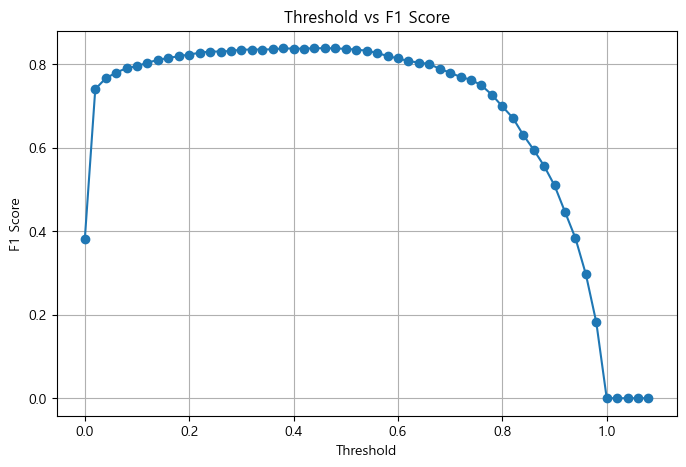

Optimal Threshold: 0.44, Max F1 Score: 0.8380


In [156]:
import numpy as np
from sklearn.metrics import f1_score

def find_optimal_threshold_for_f1(predictions_proba, y_test):
    thresholds = np.arange(0.0, 1.1, 0.02)
    f1_scores = []

    for threshold in thresholds:
        predictions = (predictions_proba > threshold).astype(int)
        f1 = f1_score(y_test, predictions)
        f1_scores.append(f1)

    optimal_threshold = thresholds[np.argmax(f1_scores)]
    max_f1_score = max(f1_scores)

    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, f1_scores, marker='o')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('Threshold vs F1 Score')
    plt.grid(True)
    plt.show()

    return optimal_threshold, max_f1_score

# 함수 사용 예시
optimal_threshold, max_f1_score = find_optimal_threshold_for_f1(predictions_proba, y_test)
print(f'Optimal Threshold: {optimal_threshold:.2f}, Max F1 Score: {max_f1_score:.4f}')

스레스 홀드 약 0.04 부터 약 0.6 까지 비슷한 f1-score를 보임  
위에서 roc 곡선을 구한 스레스 홀드 값을 기준으로 0.2을 넘어가는 기업에 대해서  
내년에 부실기업일 확률이 위험단계임을 출력

In [157]:
import numpy as np
from sklearn.metrics import f1_score

# 모델 예측
predictions_proba = model.predict(X_test_lstm).flatten()
predictions = (predictions_proba > 0.39).astype(int)

# 모델 평가
accuracy = model.evaluate(X_test_lstm, y_test, verbose=0)[1]
f1 = f1_score(y_test, predictions)

# 예측 확률이 0.21 이상인 기업 중 실제 부실기업의 비율 계산
predicted_defaulters_indices = predictions_proba > 0.39
predicted_defaulters = y_test[predicted_defaulters_indices]
actual_defaulters_ratio = np.mean(predicted_defaulters)

print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
print(f"Actual Defaulters Ratio among Predicted Defaulters: {actual_defaulters_ratio:.4f}")

259/259 [==============================] - 0s 1ms/step
Accuracy: 0.9347, F1 Score: 0.8387
Actual Defaulters Ratio among Predicted Defaulters: 0.7629


3. 부실기업 비율 기반

스레스홀드 별로 부실기업 예측확률에 해당하는 기업중 실제 부실기업에 해당하는 비율을 시각화

259/259 [==============================] - 0s 1ms/step


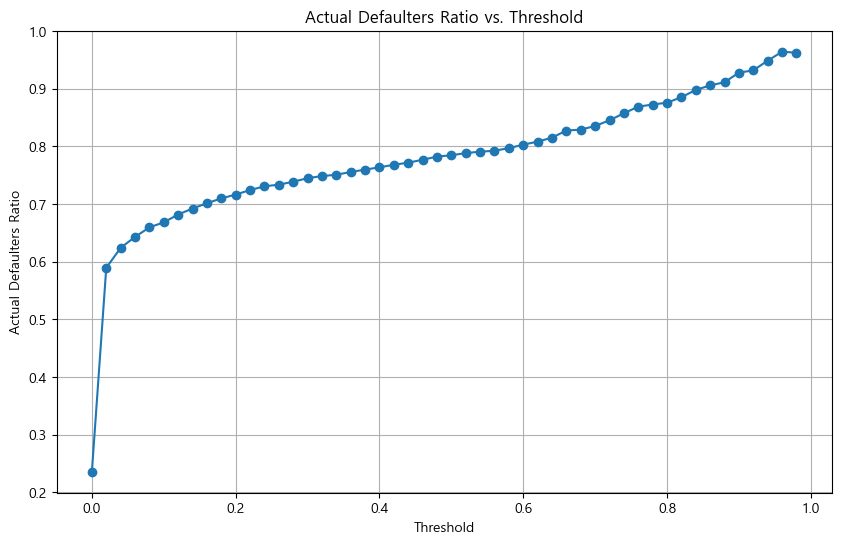

In [195]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# 모델 예측
predictions_proba = model.predict(X_test_lstm).flatten()
predictions = (predictions_proba > 0.21).astype(int)

# 다양한 임계값에 대한 실제 부실기업 비율 계산
thresholds = np.arange(0.0, 1.0, 0.02)
actual_defaulters_ratios = []

for threshold in thresholds:
    predicted_defaulters_indices = predictions_proba > threshold
    predicted_defaulters = y_test[predicted_defaulters_indices]
    if len(predicted_defaulters) > 0:
        actual_defaulters_ratio = np.mean(predicted_defaulters)
    else:
        actual_defaulters_ratio = 0
    actual_defaulters_ratios.append(actual_defaulters_ratio)

# 그래프 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, actual_defaulters_ratios, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Actual Defaulters Ratio')
plt.title('Actual Defaulters Ratio vs. Threshold')
plt.grid(True)
plt.show()

부실기업일 확률값으로 0.6이상 기업들에대해서   
실제 부실기업(TP) / 실제 부실기업(TP) + 실제 정상기업(FP)  = 0.8  
해당 스레스홀드(0.6) 을 대시보드 상에서 매우 위험상태로 출력

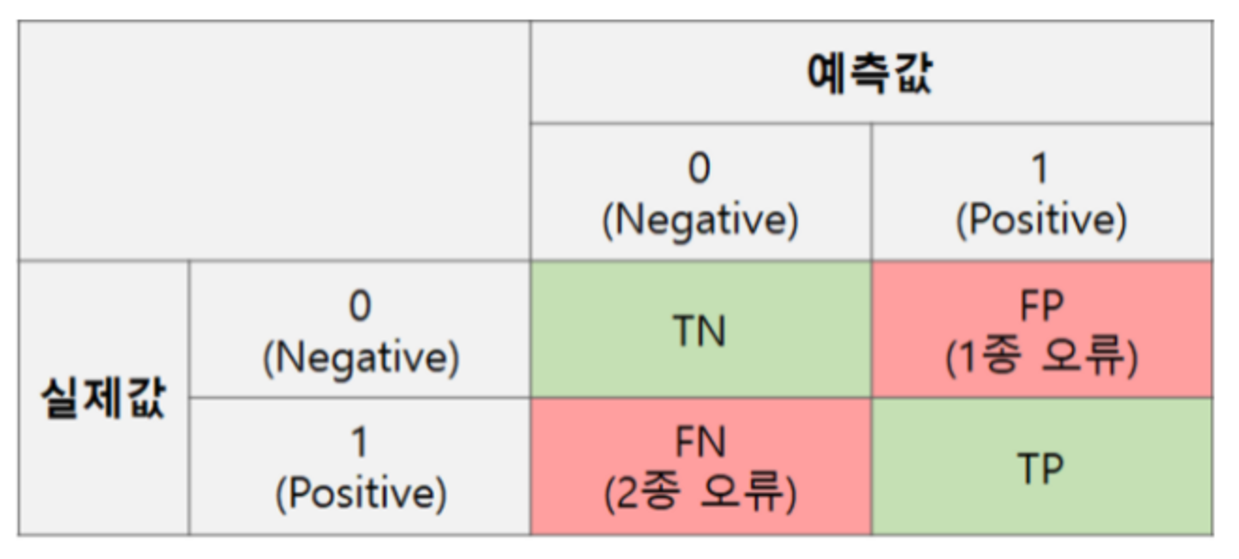

---

### 2. 모델링

In [159]:
# 모델 학습 함수
def train_models(data):
    global models, final_model

    # 종속 변수 설정
    y = data['2023/부실기업']

    # 카테고리별 변수 목록 및 설명
    categories = {
        '수익성 비율': [
            '총자본영업이익율',
            '기업법인세비용차감전순이익율',
            '경영자본영업이익율',
            '매출액법인세비용차감전순이익율',
            '자본금법인세비용차감전순이익율',
            '자본금순이익율',
            '순이익(종업원1인당)',
            '법인세차감전순이익이자보상비율',
            '영업이익이자보상비율'
        ],
        '레버리지 비율': [
            '차입금평균이자율',
            '금융비용/총비용비율'
        ],
        '유동성 비율': [
            '유동부채비율',
            '순운전자본/총자본비율',
            '현금비율'
        ],
        '자본 비율': [
            '사내유보율',
            '유보액/총자산비율',
            '임차료(구성비)'
        ],
        '효율성 비율': [
            'EBITDA대금융비용',
            '법인세차감전순이익(구성비)',
            '조세/조세차감전순이익비율',
            '금융비용(구성비)'
        ]
    }

    models = {}

    # 각 카테고리별 모델 학습
    for category, vars_list in categories.items():
        # 해당 카테고리의 데이터 준비
        X_category = data[[f'2021/{var}' for var in vars_list] + [f'2022/{var}' for var in vars_list] + ['2023/부실기업']]
        y_category = X_category['2023/부실기업']
        X_category = X_category.drop(columns=['2023/부실기업'])  # 라벨 제외

        # 데이터 정규화
        scaler_cat = StandardScaler()
        X_category_scaled = scaler_cat.fit_transform(X_category)

        # LSTM 입력 형식으로 변환
        X_category_lstm = X_category_scaled.reshape((X_category_scaled.shape[0], 1, X_category_scaled.shape[1]))

        # 모델 구축
        model = Sequential()
        model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(X_category_lstm.shape[1], X_category_lstm.shape[2])))
        model.add(LSTM(64, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

        # 모델 학습
        model.fit(X_category_lstm, y_category, epochs=10, batch_size=32, verbose=0)

        # 모델 저장
        models[category] = {
            'model': model,
            'scaler': scaler_cat,
        }

    # 모든 카테고리의 변수로 최종 모델 학습
    all_vars = [var for vars_list in categories.values() for var in vars_list]
    X_all = data[[f'2021/{var}' for var in all_vars] + [f'2022/{var}' for var in all_vars]]

    # 최종 모델 학습을 위한 데이터 준비
    y_all = data['2023/부실기업'].values  # 실제 라벨
    X_all_scaled = StandardScaler().fit_transform(X_all)  # 새로운 스케일러로 스케일링

    # LSTM 입력 형식으로 변환
    X_all_lstm = X_all_scaled.reshape((X_all_scaled.shape[0], 1, X_all_scaled.shape[1]))

    # 최종 모델 구축
    final_model = Sequential()
    final_model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(X_all_lstm.shape[1], X_all_lstm.shape[2])))
    final_model.add(LSTM(64, activation='relu'))
    final_model.add(Dense(1, activation='sigmoid'))
    final_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    # 최종 모델 학습
    final_model.fit(X_all_lstm, y_all, epochs=10, batch_size=32, verbose=1)

# 예측 및 시각화 함수
def predict_and_visualize(new_data):
    global models, final_model

    # 업체 코드와 종목명 추출
    company_code = new_data['업체코드'].values[0]
    company_name = new_data['종목명'].values[0]

    # 카테고리별 변수 목록 및 설명
    categories = {
        '수익성 비율': [
            '총자본영업이익율','기업법인세비용차감전순이익율','경영자본영업이익율',
            '매출액법인세비용차감전순이익율','자본금법인세비용차감전순이익율','자본금순이익율',
            '순이익(종업원1인당)','법인세차감전순이익이자보상비율','영업이익이자보상비율'
        ],
        
        '레버리지 비율': [
            '차입금평균이자율','금융비용/총비용비율'
        ],

        '유동성 비율': [
            '유동부채비율','순운전자본/총자본비율','현금비율'
        ],

        '자본 비율': [
            '사내유보율','유보액/총자산비율','임차료(구성비)'  
        ],

        '효율성 비율': [
            'EBITDA대금융비용','법인세차감전순이익(구성비)',
            '조세/조세차감전순이익비율','금융비용(구성비)'
        ]
    }

    predicted_probabilities = []

    # 각 카테고리별 모델 예측
    for category, data in models.items():
        model = data['model']
        scaler = data['scaler']

        # 새로운 데이터에서 해당 카테고리의 변수만 선택 (2021년과 2022년 변수 모두 포함)
        new_data_filtered = new_data[[f'2021/{var}' for var in categories[category]] + [f'2022/{var}' for var in categories[category]]]

        # 새로운 데이터 정규화
        new_data_scaled = scaler.transform(new_data_filtered)

        # LSTM 입력 형식으로 변환
        new_data_lstm = new_data_scaled.reshape((new_data_scaled.shape[0], 1, new_data_scaled.shape[1]))

        # 예측 수행
        predictions_proba = model.predict(new_data_lstm)
        predicted_probability = np.mean(predictions_proba)  # 평균 확률을 사용
        predicted_probabilities.append(predicted_probability)

    # 방사형 차트 시각화
    def create_radar_chart(ax, data, categories, title):
        num_vars = len(categories)
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        
        # 첫 번째 값을 끝에 추가하여 연결
        data = np.concatenate((data, [data[0]]))
        angles += angles[:1]

        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)

        ax.set_rlabel_position(0)
        ax.set_ylim(0, 1)  # y축 범위를 0에서 1로 고정
        ax.plot(angles, data, color='blue', linewidth=2, linestyle='solid')
        ax.fill(angles, data, color='blue', alpha=0.25)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, fontsize=12)
        ax.set_title(title, size=15, y=1.1)

    # 서브플롯으로 방사형 차트와 세로 방향 막대 그래프 그리기
    fig, axs = plt.subplots(1, 2, figsize=(20, 6), gridspec_kw={'width_ratios': [2, 1]})

    # 방사형 차트 그리기
    ax_radar = plt.subplot(1, 2, 1, polar=True)
    create_radar_chart(ax_radar, predicted_probabilities, list(models.keys()), "재무군집별 부실기업 예측 확률")

    # 세로 방향 막대 그래프 그리기
    ax_bar = plt.subplot(1, 2, 2)
    probability = np.mean(predicted_probabilities)
    
    # 위험도 레벨 결정
    if probability < 0.2:
        risk_level = "낮음"
    elif probability < 0.6:
        risk_level = "위험"
    else:
        risk_level = "매우 위험"
    
    ax_bar.barh([company_name], [probability], color='orange')
    ax_bar.axvline(x=0.2, color='green', linestyle='--', label='Threshold (0.2)')
    ax_bar.axvline(x=0.6, color='red', linestyle='--', label='Threshold (0.6)')
    ax_bar.set_xlim(0, 1)
    ax_bar.set_xlabel('Probability')
    ax_bar.set_title(f"부실기업 위험도 - [ {risk_level} ]")
    ax_bar.legend()

    # 확률값 수치 추가
    ax_bar.text(probability, 0, f'{probability:.2f}', ha='center', va='bottom', fontsize=12, color='black')

    # 공통 제목 설정
    fig.suptitle(f'재무비율 기반 부실기업 예측 : ({company_code}, {company_name})', fontsize=20, y=0.95)

    # 서브플롯 간의 간격 조정
    plt.subplots_adjust(wspace=0.1)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# 데이터 로드 및 모델 학습
data_21to22 = pd.read_csv("../../project/data/data_21to22.csv", encoding='utf-8-sig', low_memory=False)
train_models(data_21to22)

Epoch 1/10
863/863 [==============================] - 4s 3ms/step - loss: 0.2606 - accuracy: 0.8913
Epoch 2/10
863/863 [==============================] - 2s 2ms/step - loss: 0.1813 - accuracy: 0.9202
Epoch 3/10
863/863 [==============================] - 2s 2ms/step - loss: 0.1617 - accuracy: 0.9291
Epoch 4/10
863/863 [==============================] - 2s 2ms/step - loss: 0.1521 - accuracy: 0.9335
Epoch 5/10
863/863 [==============================] - 2s 2ms/step - loss: 0.1457 - accuracy: 0.9354
Epoch 6/10
863/863 [==============================] - 3s 3ms/step - loss: 0.1407 - accuracy: 0.9379
Epoch 7/10
863/863 [==============================] - 2s 2ms/step - loss: 0.1371 - accuracy: 0.9389
Epoch 8/10
863/863 [==============================] - 2s 2ms/step - loss: 0.1337 - accuracy: 0.9404
Epoch 9/10
863/863 [==============================] - 2s 2ms/step - loss: 0.1304 - accuracy: 0.9430
Epoch 10/10
863/863 [==============================] - 2s 3ms/step - loss: 0.1266 - accuracy: 0.9436

In [160]:
# '2023/부실기업' 변수의 값이 1인 행 필터링
bankrupt_indices = data_21to22[data_21to22['2023/부실기업'] == 1].index

# 상위 30개 인덱스 출력
print(bankrupt_indices[:30])

Int64Index([  1,   8,  11,  17,  29,  31,  32,  38,  40,  47,  55,  56,  61,
             64,  68,  79,  81,  86,  89, 100, 106, 112, 116, 118, 123, 135,
            138, 145, 152, 169],
           dtype='int64')


#### [ 부실기업 x ]

1/1 [==============================] - 0s 197ms/step


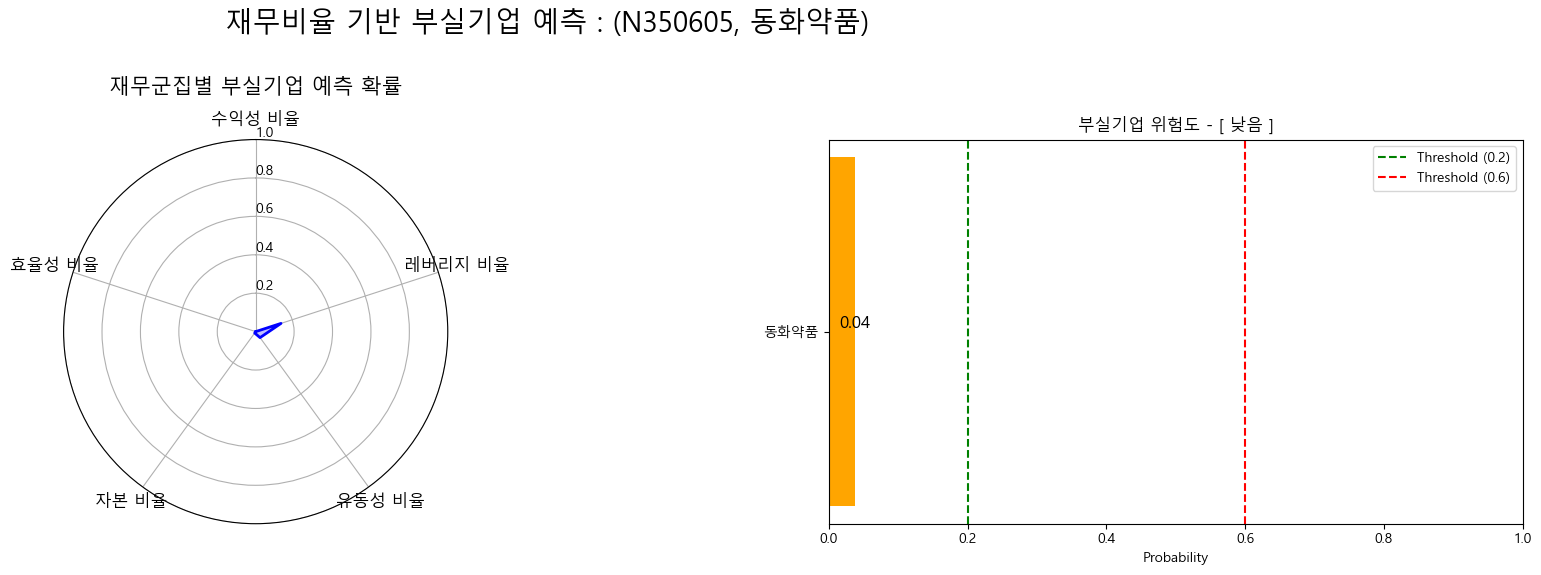

In [161]:
# 특정 인덱스의 데이터 선택
index = 0  # 원하는 인덱스
new_data = data_21to22.iloc[[index]]  # 인덱스에 해당하는 데이터 선택

# 예측 및 시각화 수행
predict_and_visualize(new_data)

1/1 [==============================] - 0s 14ms/step


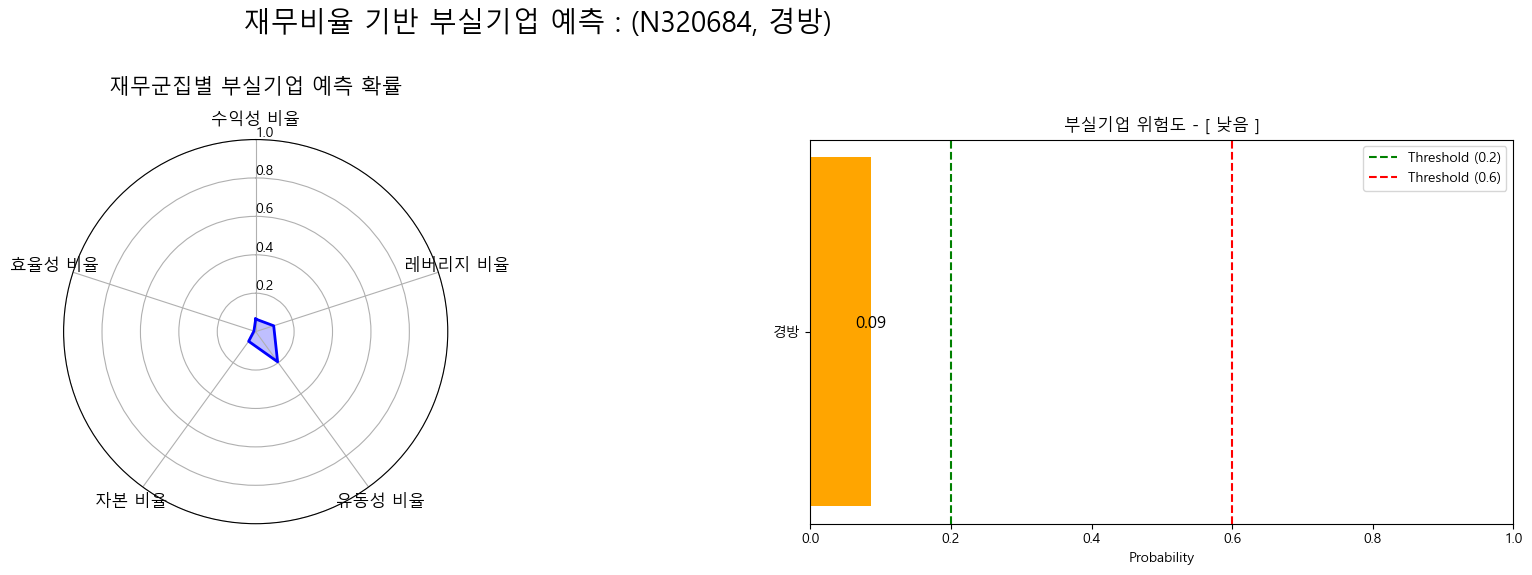

In [162]:
# 특정 인덱스의 데이터 선택
index = 2  # 원하는 인덱스
new_data = data_21to22.iloc[[index]]  # 인덱스에 해당하는 데이터 선택

# 예측 및 시각화 수행
predict_and_visualize(new_data)

1/1 [==============================] - 0s 14ms/step


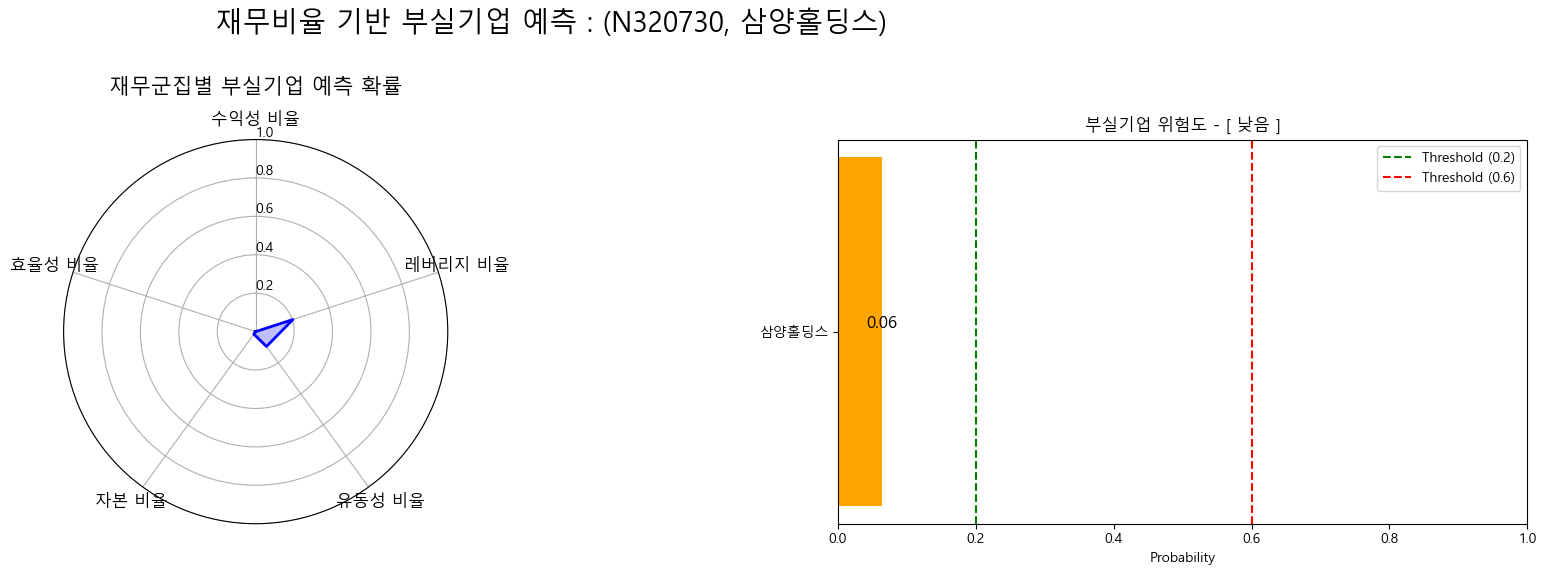

In [163]:
# 특정 인덱스의 데이터 선택
index = 3  # 원하는 인덱스
new_data = data_21to22.iloc[[index]]  # 인덱스에 해당하는 데이터 선택

# 예측 및 시각화 수행
predict_and_visualize(new_data)

#### [ 부실기업 o ]

1/1 [==============================] - 0s 14ms/step


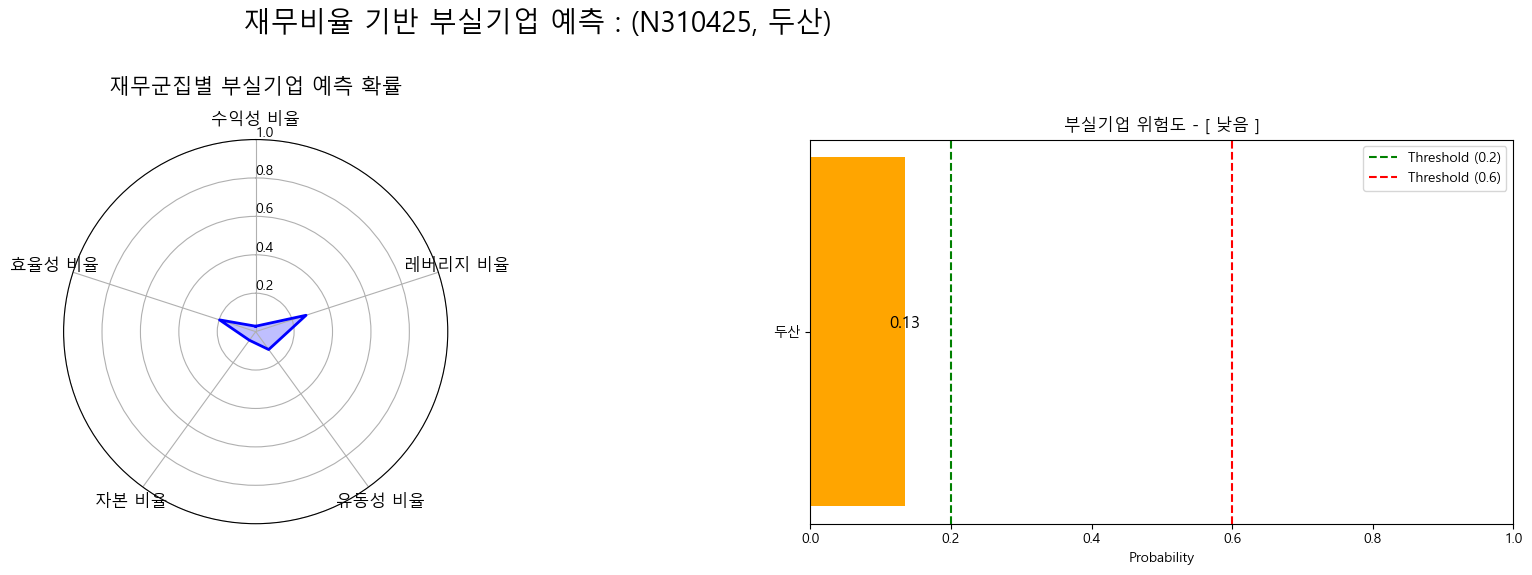

In [193]:
# 특정 인덱스의 데이터 선택
index = 8  # 원하는 인덱스
new_data = data_21to22.iloc[[index]]  # 인덱스에 해당하는 데이터 선택

# 예측 및 시각화 수행
predict_and_visualize(new_data)

1/1 [==============================] - 0s 14ms/step


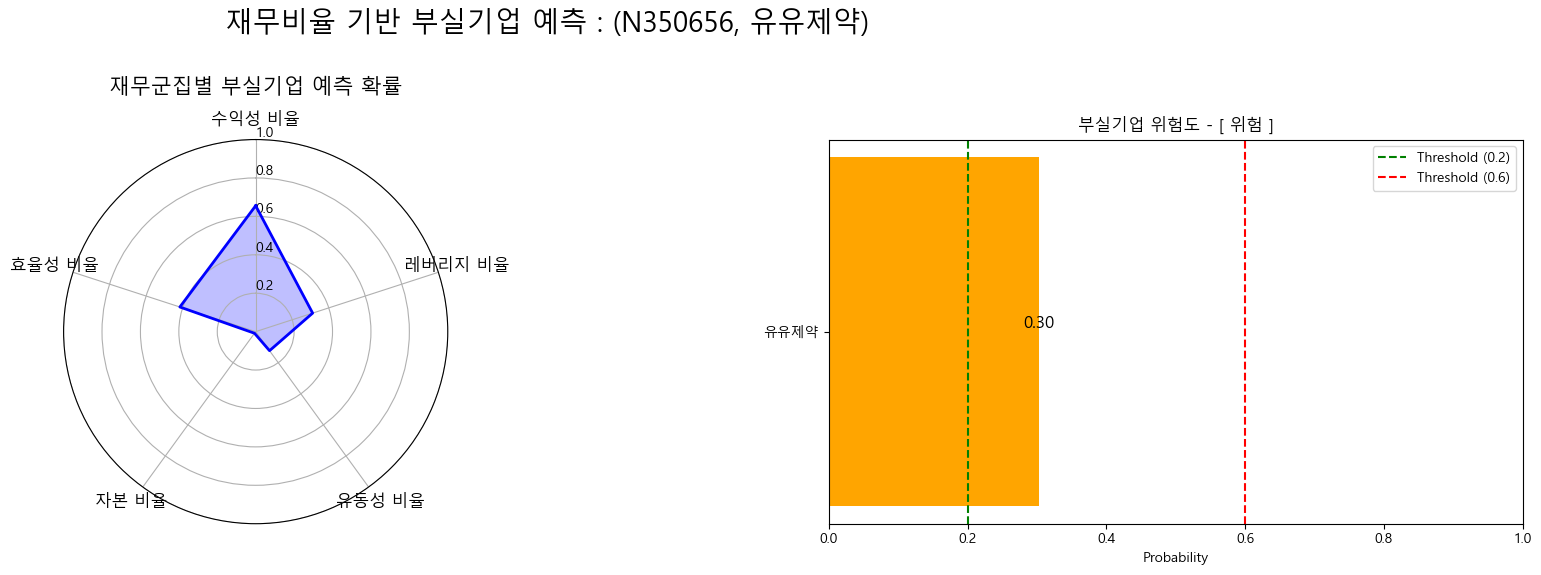

In [ ]:
# 특정 인덱스의 데이터 선택
index = 11  # 원하는 인덱스
new_data = data_21to22.iloc[[index]]  # 인덱스에 해당하는 데이터 선택

# 예측 및 시각화 수행
predict_and_visualize(new_data)

1/1 [==============================] - 0s 15ms/step


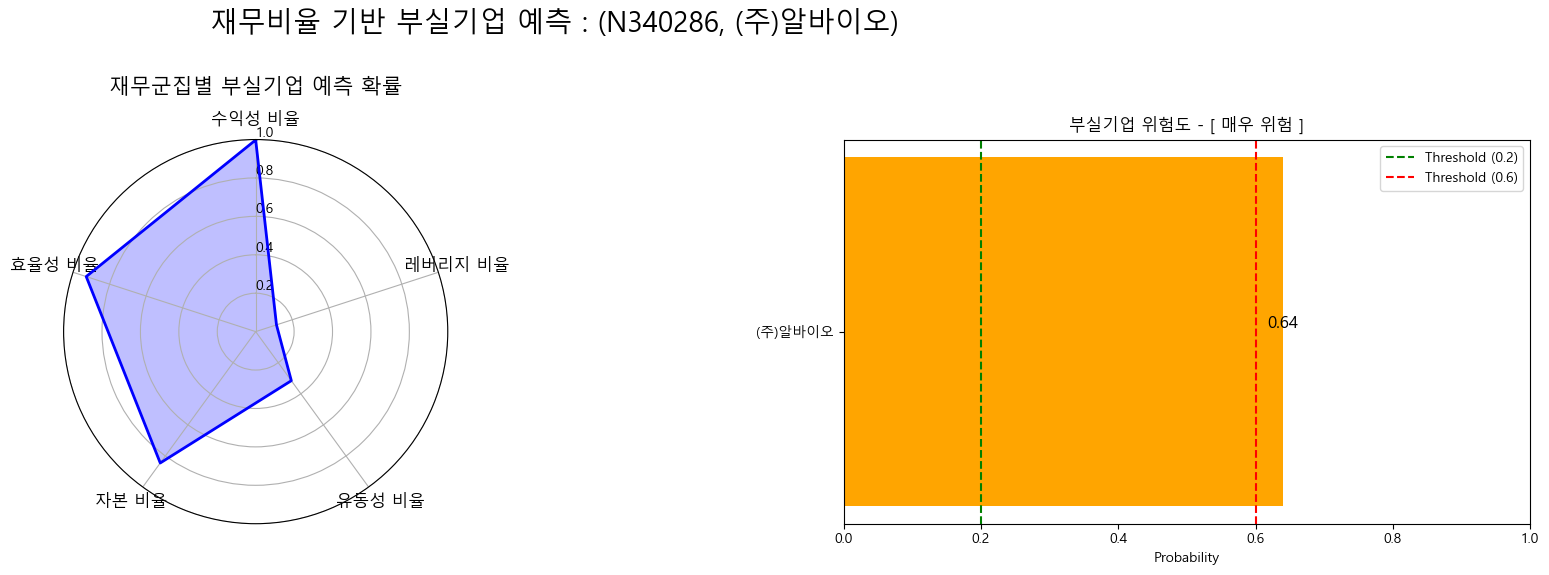

In [191]:
# 특정 인덱스의 데이터 선택
index = 152  # 원하는 인덱스
new_data = data_21to22.iloc[[index]]  # 인덱스에 해당하는 데이터 선택

# 예측 및 시각화 수행
predict_and_visualize(new_data)

.